# Flight Final Descent Anomaly Detection and Classification

Contributors: Elan Wilkinson, Melissa Short, Nicholas Short

## Setup Dependencies

In [ ]:
!pip install --disable-pip-version-check -q pip --upgrade > /dev/null
!pip install --disable-pip-version-check -q wrapt --upgrade > /dev/null

### AWS CLI and AWS Python SDK (boto3)

In [ ]:
!pip install --disable-pip-version-check -q awscli boto3

### SageMaker

In [ ]:
!pip install --disable-pip-version-check -q sagemaker
!pip install --disable-pip-version-check -q smdebug
!pip install --disable-pip-version-check -q sagemaker-experiments

### PyAthena

In [ ]:
!pip install --disable-pip-version-check -q PyAthena

### AWS Data Wrangler

In [ ]:
!pip install --disable-pip-version-check -q awswrangler

### Zip

In [ ]:
!conda install -y zip

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



### Matplotlib

In [ ]:
!pip install --disable-pip-version-check -q matplotlib

### Seaborn

In [ ]:
!pip install --disable-pip-version-check -q seaborn

## Data lake Setup

In [ ]:
import boto3
import sagemaker

session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = 'flightfinalapproachanomalydetection'#'sagemaker-us-east-1-817854913925' #sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

print("Bucket name: {}".format(bucket))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket name: flightfinalapproachanomalydetection


### Verify Bucket Creation

In [ ]:
from botocore.client import ClientError

response = None
try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': 'H59G1FBRW43JAHMB', 'HostId': 'GBjj1QDvwW8EebNyx8DvHMMDvhC+JE/L/iLk5lO2biFeuNuKkwa7FZRksPxFPmBYESCc8fu2sXqUtGc51ojRf7yu3VmSckucj8uwl+Dnf9w=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'GBjj1QDvwW8EebNyx8DvHMMDvhC+JE/L/iLk5lO2biFeuNuKkwa7FZRksPxFPmBYESCc8fu2sXqUtGc51ojRf7yu3VmSckucj8uwl+Dnf9w=', 'x-amz-request-id': 'H59G1FBRW43JAHMB', 'date': 'Fri, 31 Jan 2025 02:08:41 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [ ]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client(service_name="sagemaker", region_name=region)

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/flightfinalapproachanomalydetection/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

/tmp/ipykernel_1381/88463448.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


## Exploratory Data Analysis

## Create Athena Database Scheme
### Import PyAthena

In [ ]:
from pyathena import connect

In [ ]:
table_name_csv = "flight_csv_data"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

### Create Athena Database

In [ ]:
database_name = "flightdata_db"

In [ ]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [ ]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [ ]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS flightdata_db


In [ ]:
cursor = conn.cursor()
cursor.execute(statement)
print("Database created successfully")


Database created successfully


In [ ]:
import pandas as pd

statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_1381/2310636415.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


database_name
0         assignment2_aws
1                 default
2                  dsoaws
3           flightdata_db
4  sagemaker_featurestore

## Register CSV with Athena

In [ ]:
drop_statement = "DROP TABLE flightdata_db.flight_csv_data"
cursor = conn.cursor()
cursor.execute(drop_statement)
print("Table dropped successfully.")

Table dropped successfully.


In [ ]:
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS flightdata_db.flight_csv_data (
        sample_id int,
        timestep int,
        aileron_pos_lh_deg float,
        aileron_pos_rh_deg float,
        corrected_angle_of_attack_deg float,
        baro_correct_alt_lsp_ft float,
        computed_airspeed_lsp_knots float,
        selected_course_deg float,
        drift_angle_deg float,
        elevator_pos_left_deg float,
        te_flap_pos_disc float,
        glideslope_dev_perc float,
        selected_heading_deg float,
        localizer_dev_perc float,
        core_speed_avg_perc float,
        total_pressure_lsp_millibar float,
        pitch_angle_lsp_deg float,
        roll_angle_lsp_deg float,
        rudder_pos_deg float,
        true_heading_lsp_deg float,
        vertical_accel_g float,
        wind_speed_knots float,
        label int
)
STORED AS TEXTFILE
LOCATION 's3://flightfinalapproachanomalydetection/csv/'
TBLPROPERTIES (
    'skip.header.line.count'='1',
    'field.delim'=',',
    'compressionType'='none'
)"""

In [ ]:
cursor = conn.cursor()
cursor.execute(statement)

In [ ]:
import pandas as pd
pd.read_sql(statement, conn)

/tmp/ipykernel_14886/1322682284.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


Empty DataFrame
Columns: []
Index: []

In [ ]:
statement = "SHOW TABLES IN {}".format(database_name)
cursor = conn.cursor()
cursor.execute(statement)

In [ ]:
if table_name_csv in df_show.values:
    ingest_create_athena_table_csv_passed = True
else:
    ingest_create_athena_table_csv_passed = False
print(ingest_create_athena_table_csv_passed)

False


In [ ]:
print(database_name)
print(table_name_csv)

flightdata_db
flight_csv_data


In [ ]:
statement = """SELECT sample_id, aileron_pos_lh_deg, timestep, label FROM {}.{}
    LIMIT 10""".format(
    database_name, table_name_csv
)

print(statement)

df = pd.read_sql(statement, conn)
df.head(5)

SELECT sample_id, aileron_pos_lh_deg, timestep, label FROM flightdata_db.flight_csv_data
    LIMIT 10


/tmp/ipykernel_188/1784874562.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


sample_id  aileron_pos_lh_deg  timestep  label
0          0           81.261190         0      0
1          0           79.604095         1      0
2          0           81.302110         2      0
3          0           82.345470         3      0
4          0           81.874930         4      0

In [ ]:
statement = """SELECT label, COUNT(*) AS count
    FROM {}.{}
    GROUP BY label
    ORDER BY label""".format(
    database_name, table_name_csv
)


df = pd.read_sql(statement, conn)
df.head(10)

/tmp/ipykernel_188/624500045.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


label     count
0      0  14346080
1      1   1122080
2      2    353120
3      3    152640

The classes are significantly imbalanced, with 14 million nominal examples, 1 million speed high examples, 350,000 path high examples and 152,000 flaps late setting examples. It should be noted that this is time series data, so the number of individual flight recordings is a fraction of this.

### Check for Duplicates

In [ ]:
statement = """SELECT *, COUNT(*)
    FROM {}.{}
    GROUP BY sample_id, aileron_pos_lh_deg, timestep, aileron_pos_rh_deg, corrected_angle_of_attack_deg, baro_correct_alt_lsp_ft, computed_airspeed_lsp_knots,
    selected_course_deg, drift_angle_deg, elevator_pos_left_deg, te_flap_pos_disc, glideslope_dev_perc, selected_heading_deg, localizer_dev_perc, core_speed_avg_perc,
    total_pressure_lsp_millibar, pitch_angle_lsp_deg, roll_angle_lsp_deg, rudder_pos_deg, true_heading_lsp_deg, vertical_accel_g, wind_speed_knots, label
    HAVING COUNT(*) > 1""".format(
    database_name, table_name_csv
)

df = pd.read_sql(statement, conn)
df.head(10)


/tmp/ipykernel_188/2534158001.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


Empty DataFrame
Columns: [sample_id, timestep, aileron_pos_lh_deg, aileron_pos_rh_deg, corrected_angle_of_attack_deg, baro_correct_alt_lsp_ft, computed_airspeed_lsp_knots, selected_course_deg, drift_angle_deg, elevator_pos_left_deg, te_flap_pos_disc, glideslope_dev_perc, selected_heading_deg, localizer_dev_perc, core_speed_avg_perc, total_pressure_lsp_millibar, pitch_angle_lsp_deg, roll_angle_lsp_deg, rudder_pos_deg, true_heading_lsp_deg, vertical_accel_g, wind_speed_knots, label, _col23]
Index: []

[0 rows x 24 columns]

#### Check for Null or Missing Values

In [ ]:
!pwd

/home/sagemaker-user/FlightFinalApproachAnomalyDetection


In [ ]:
import pandas as pd
df = pd.read_csv("/home/sagemaker-user/FlightFinalApproachAnomalyDetection/training_flight_data.csv")

In [ ]:

df.columns = ['sample_id', 'time_step', 'aileron_pos_lh_deg', 'aileron_pos_rh_deg', 'corrected_angle_of_attack_deg', 'baro_correct_alt_lsp_ft', 'computed_airspeed_lsp_knots',
    'selected_course_deg', 'drift_angle_deg', 'elevator_pos_left_deg', 'te_flap_pos_disc', 'glideslope_dev_perc', 'selected_heading_deg', 'localizer_dev_perc', 'core_speed_avg_perc',
    'total_pressure_lsp_millibar', 'pitch_angle_lsp_deg', 'roll_angle_lsp_deg', 'rudder_pos_deg', 'true_heading_lsp_deg', 'vertical_accel_g', 'wind_speed_knots', 'label']

In [ ]:
missing_count = df.isnull().sum()

print(df.isnull().sum())

sample_id                        0
time_step                        0
aileron_pos_lh_deg               0
aileron_pos_rh_deg               0
corrected_angle_of_attack_deg    0
baro_correct_alt_lsp_ft          0
computed_airspeed_lsp_knots      0
selected_course_deg              0
drift_angle_deg                  0
elevator_pos_left_deg            0
te_flap_pos_disc                 0
glideslope_dev_perc              0
selected_heading_deg             0
localizer_dev_perc               0
core_speed_avg_perc              0
total_pressure_lsp_millibar      0
pitch_angle_lsp_deg              0
roll_angle_lsp_deg               0
rudder_pos_deg                   0
true_heading_lsp_deg             0
vertical_accel_g                 0
wind_speed_knots                 0
label                            0
dtype: int64


In [ ]:
float_columns = [col for col in df.columns if col not in ['sample_id', 'time_step', 'label'] and df[col].dtype == 'float64']


### Average Column Value by Category Per Time Step

20


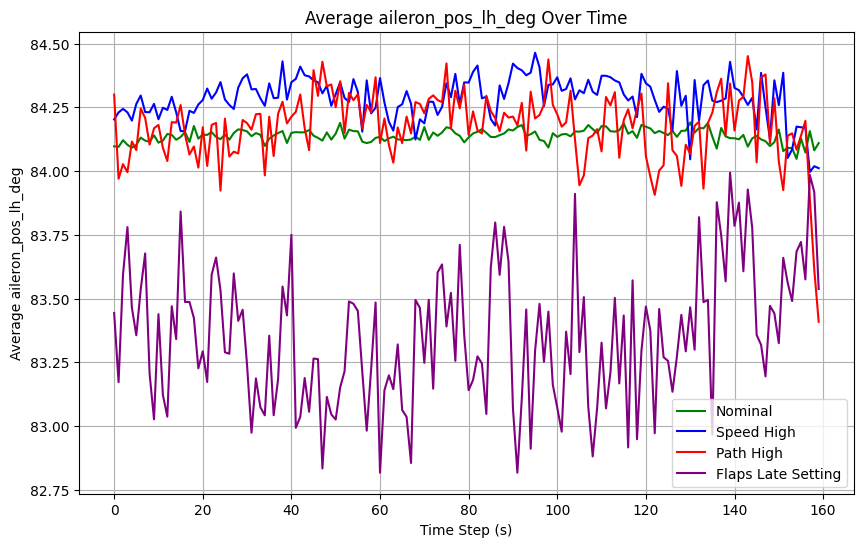

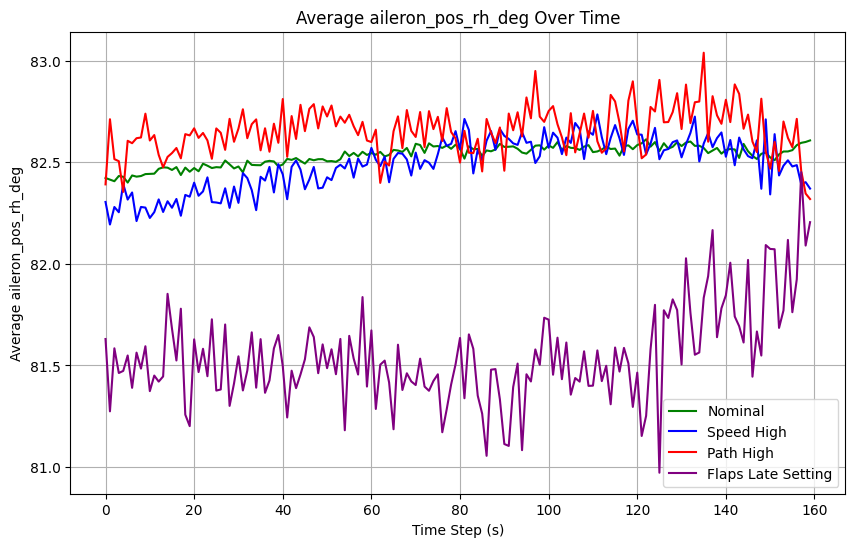

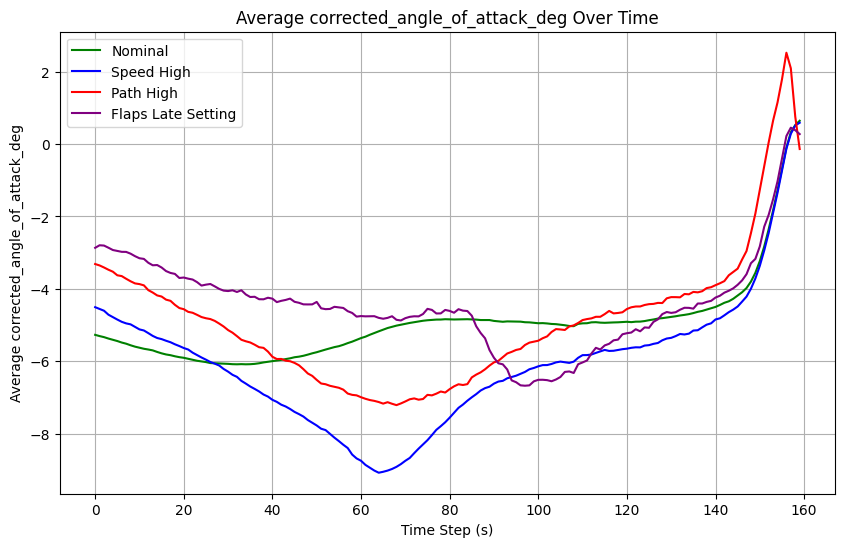

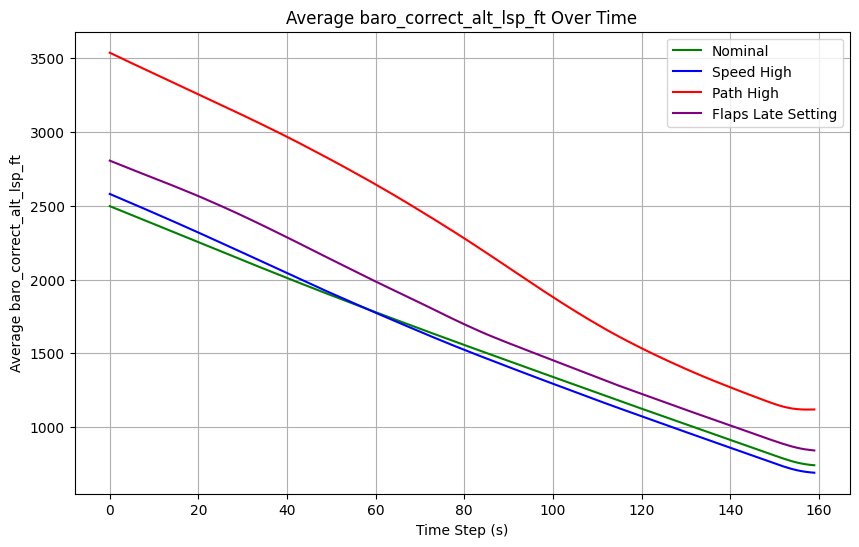

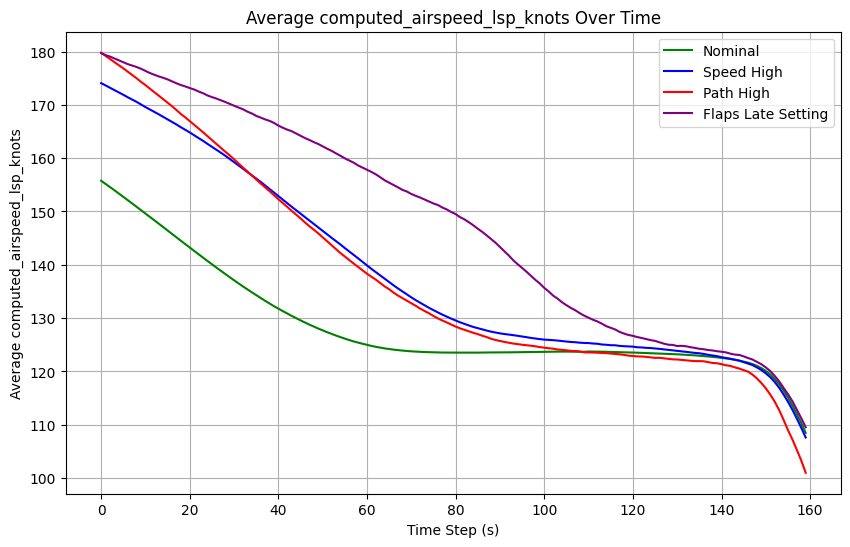

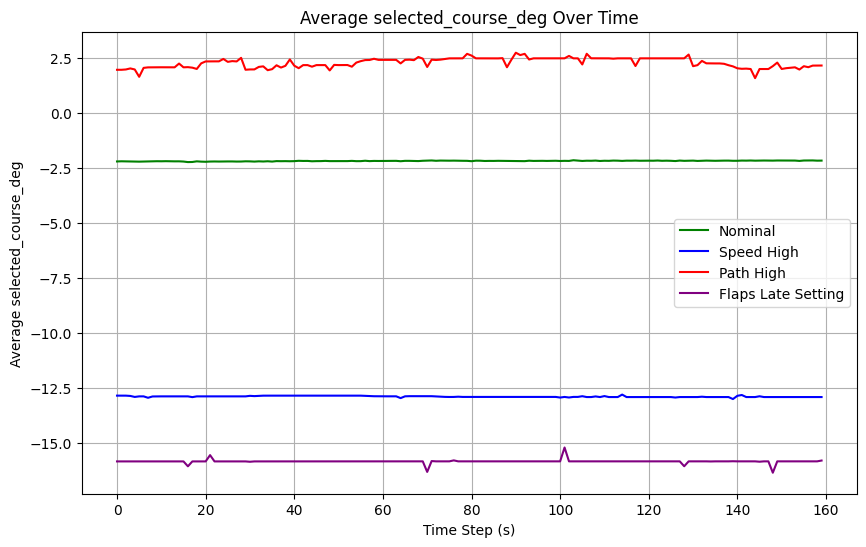

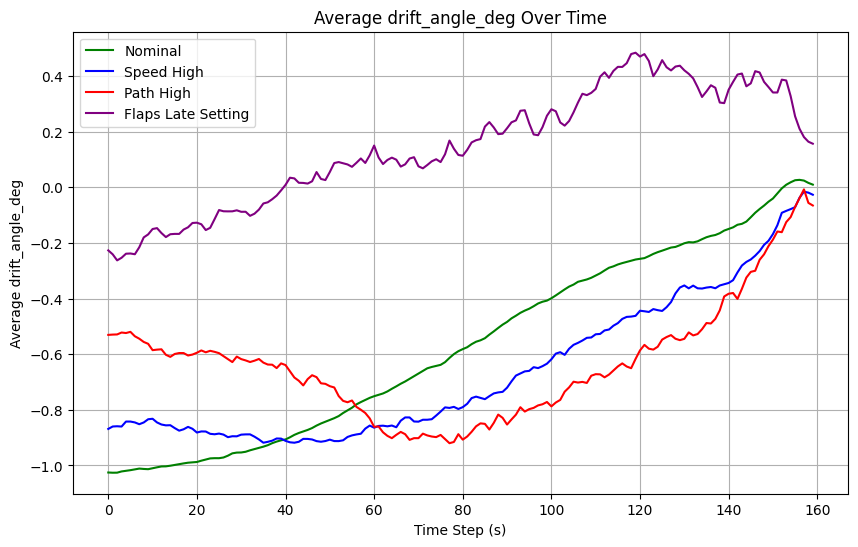

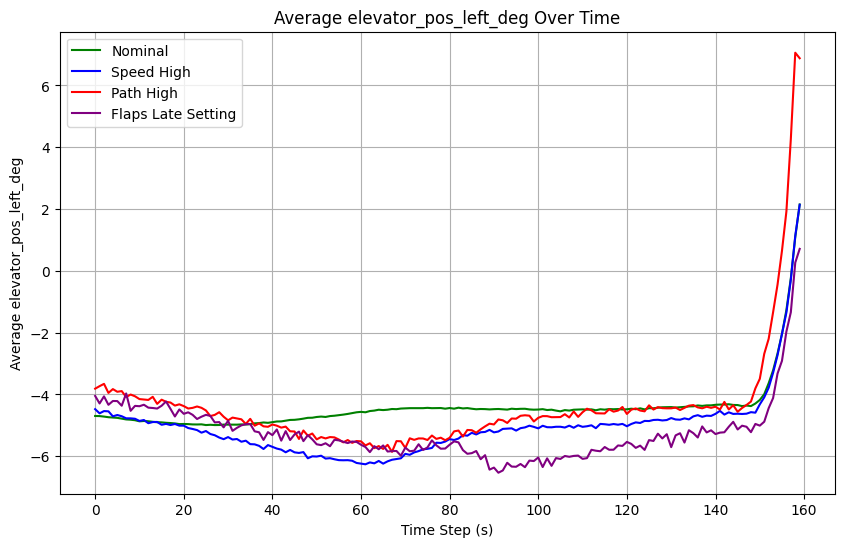

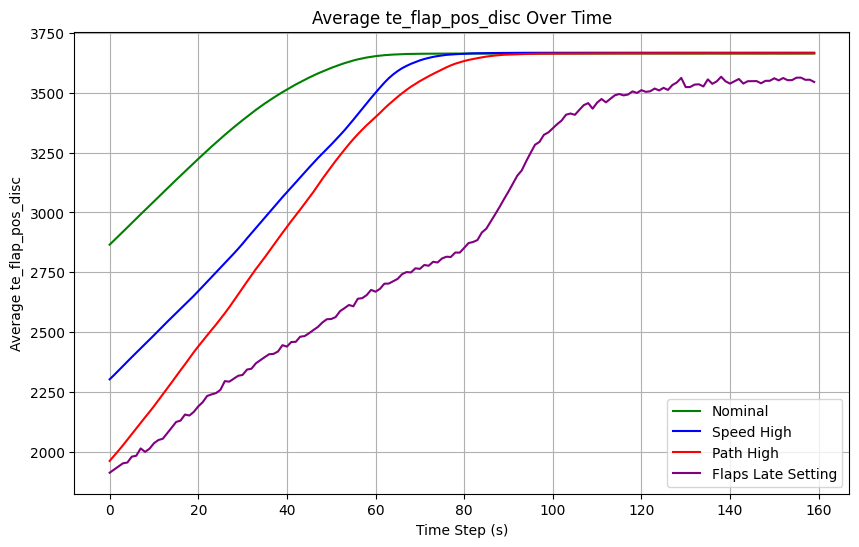

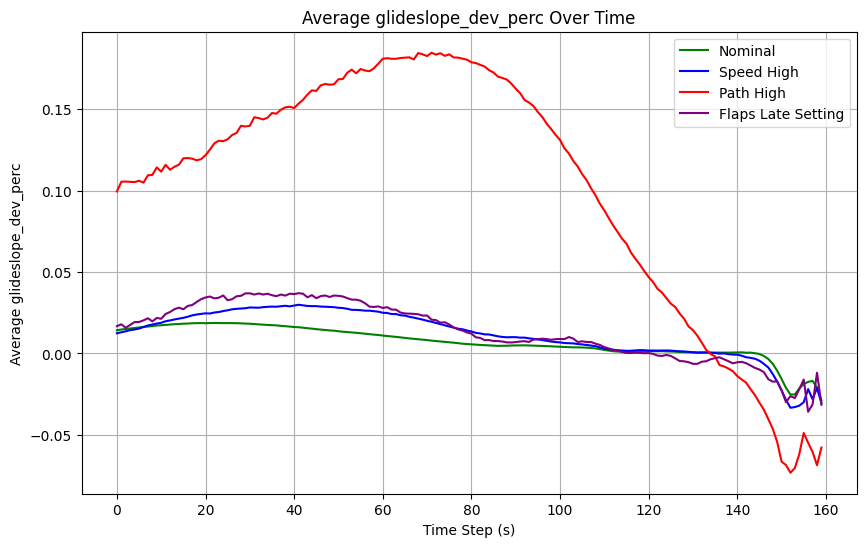

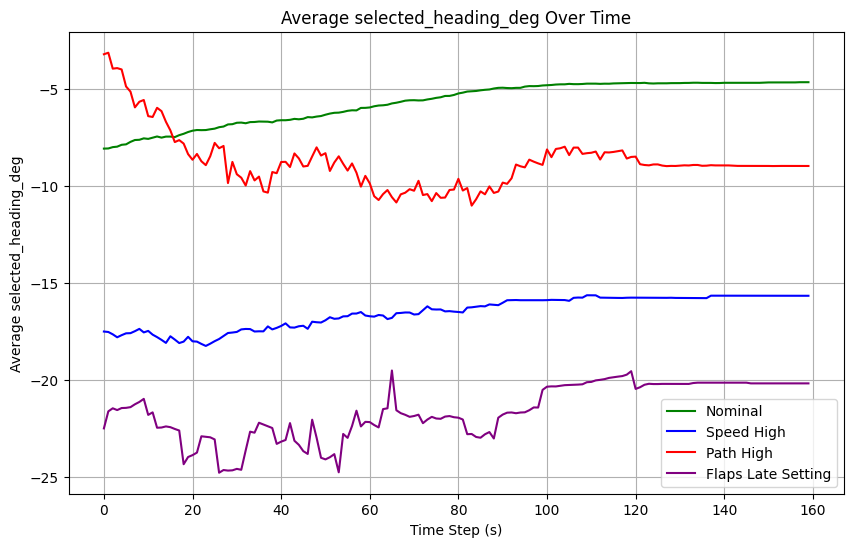

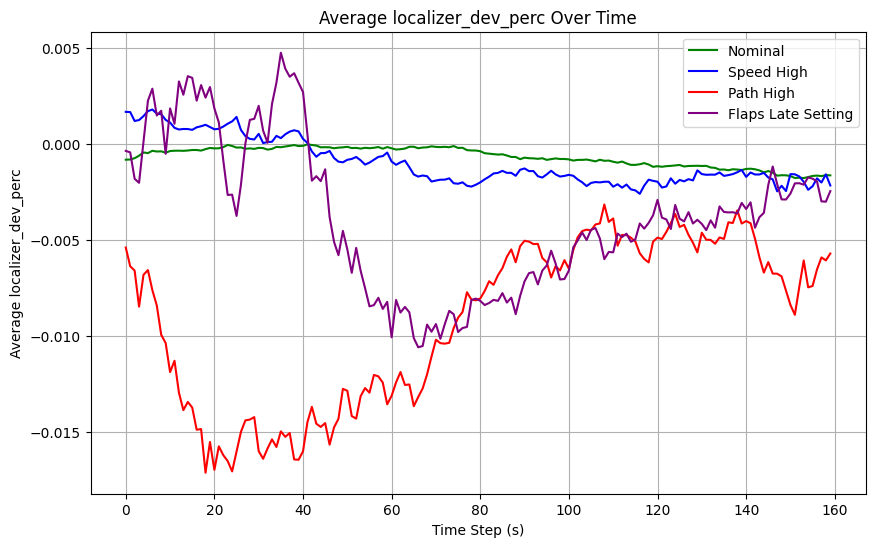

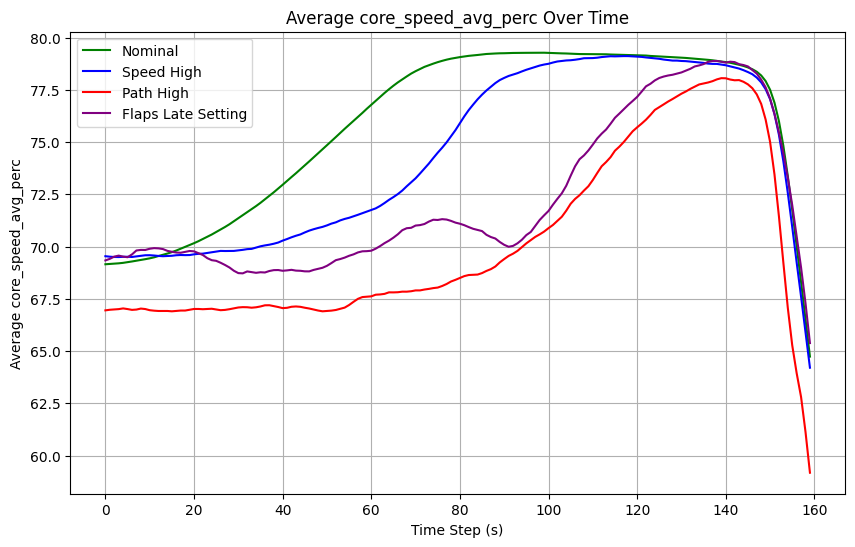

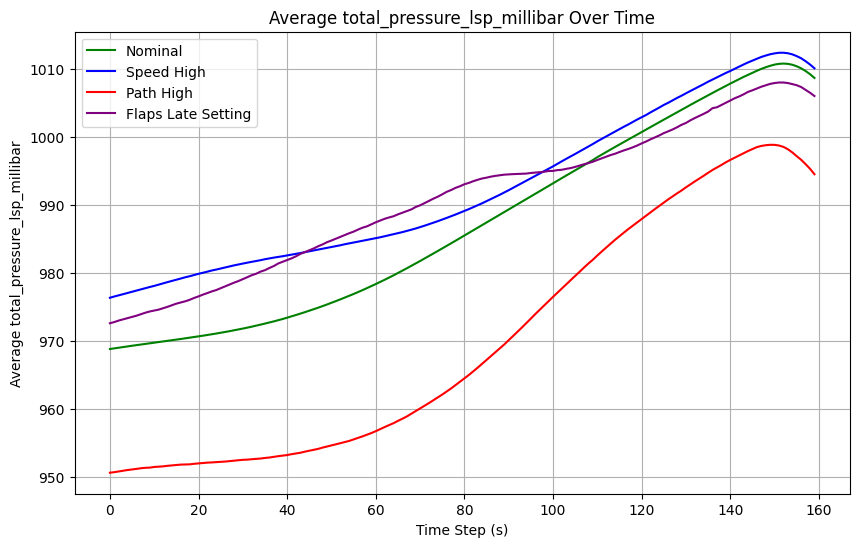

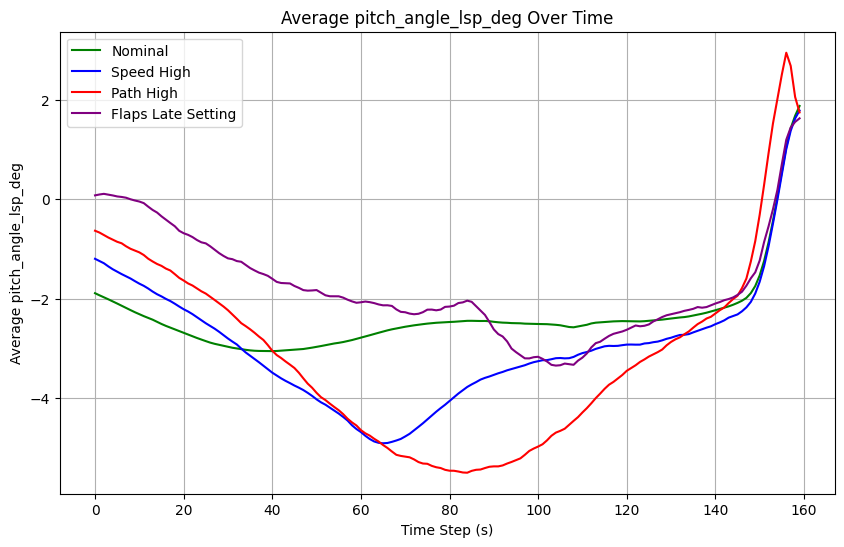

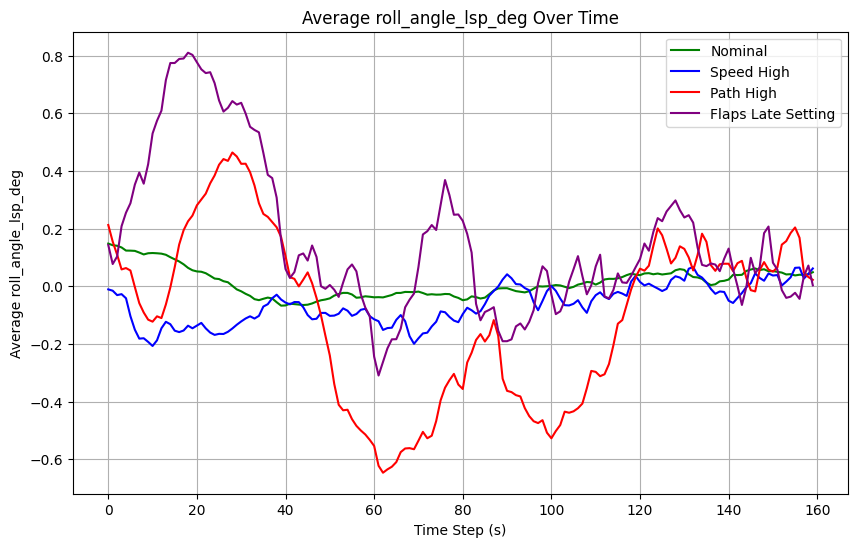

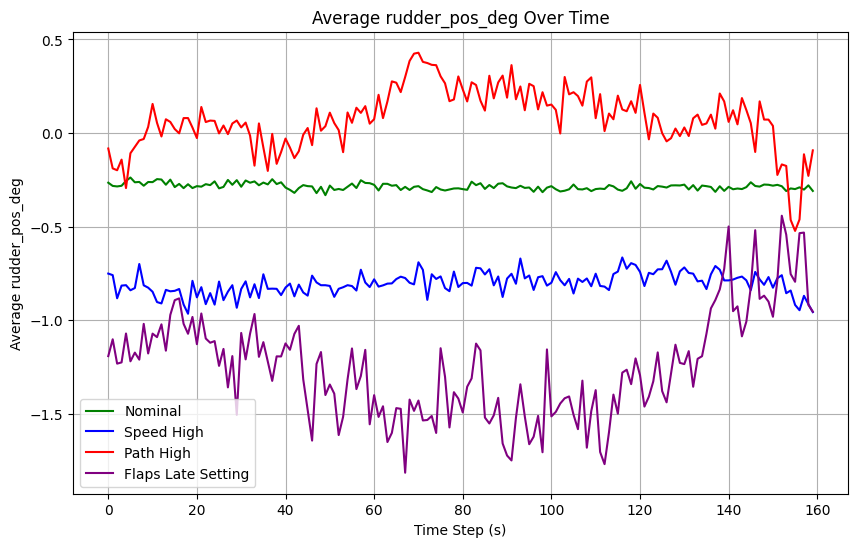

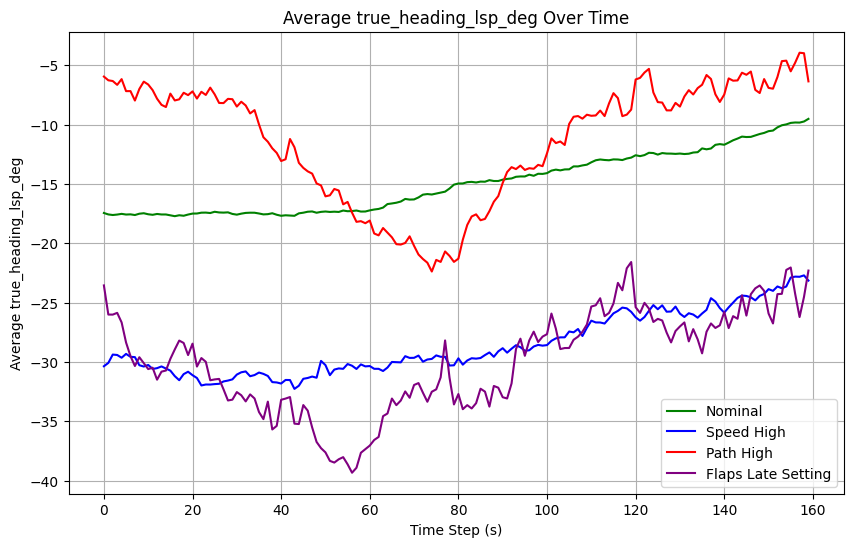

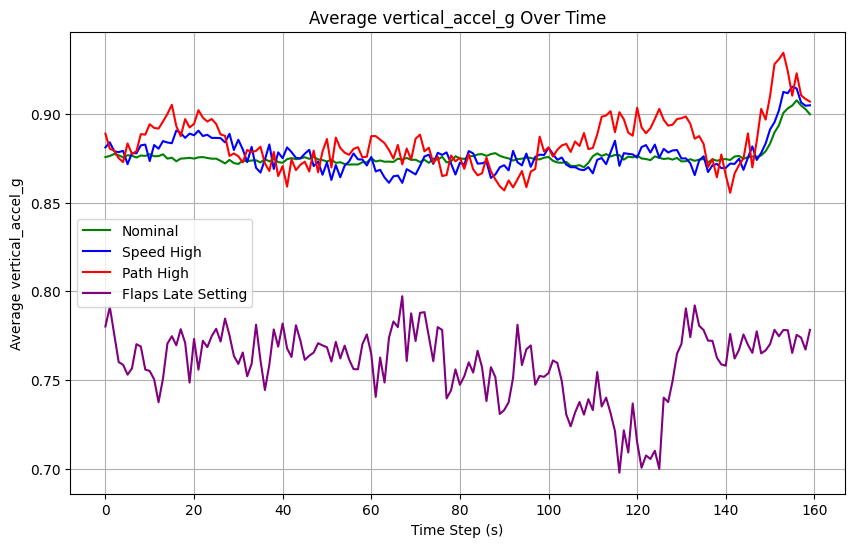

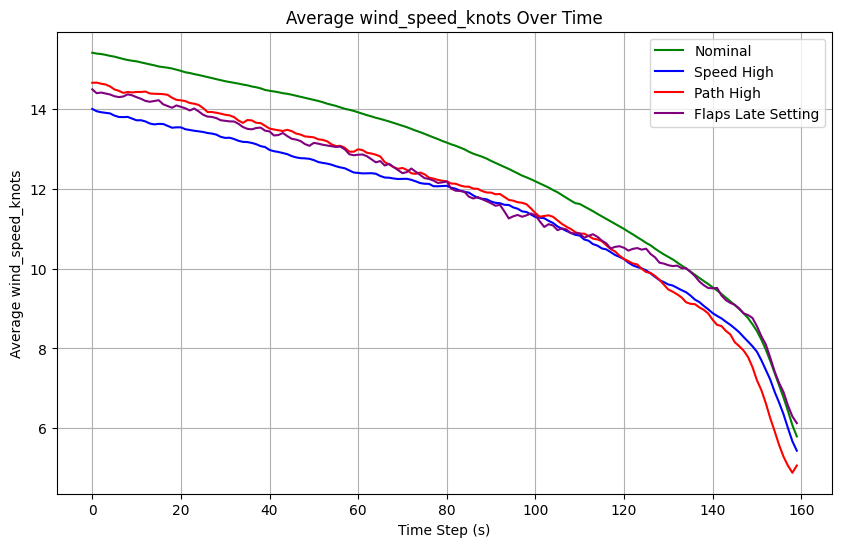

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['label'] = df['label'].astype(int)


labels = [0, 1, 2, 3]
colors = {0: 'green', 1: 'blue', 2: 'red', 3: 'purple'}

custom_labels = {0: 'Nominal', 1: 'Speed High', 2: 'Path High', 3: 'Flaps Late Setting'}

# Identify float columns (excluding 'sample_id', 'time_step', and 'label')
float_columns = [col for col in df.columns if col not in ['sample_id', 'time_step', 'label'] and df[col].dtype == 'float64']
print(len(float_columns))
# Iterate through each float column
for column in float_columns:
    plt.figure(figsize=(10, 6))

    # Plot the average value at each time_step for each label
    for label in labels:
        # Filter by label
        label_data = df[df['label'] == label]

        # Group by time_step and calculate the mean
        mean_values = label_data.groupby('time_step')[column].mean()

        # Plot the line
        plt.plot(mean_values.index, mean_values.values, label=custom_labels[label], color=colors[label])



    plt.title(f'Average {column} Over Time')
    plt.xlabel('Time Step (s)')
    plt.ylabel(f'Average {column}')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Boxplots of Data Distribution

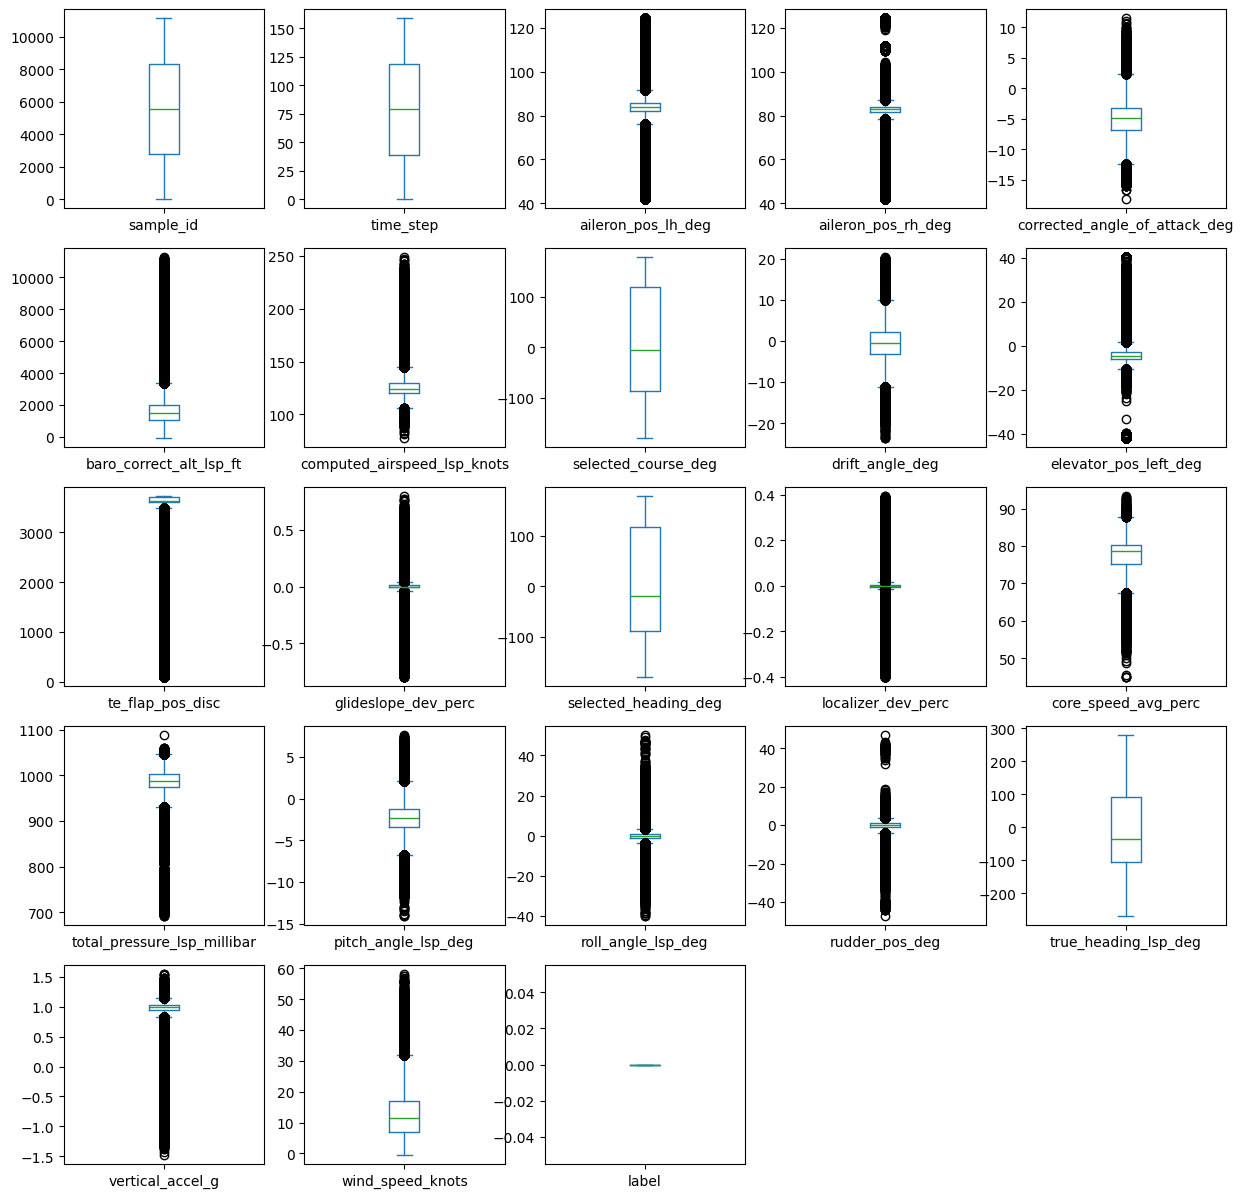

In [ ]:
import matplotlib.pyplot as plt

df.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 15))
plt.show()

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


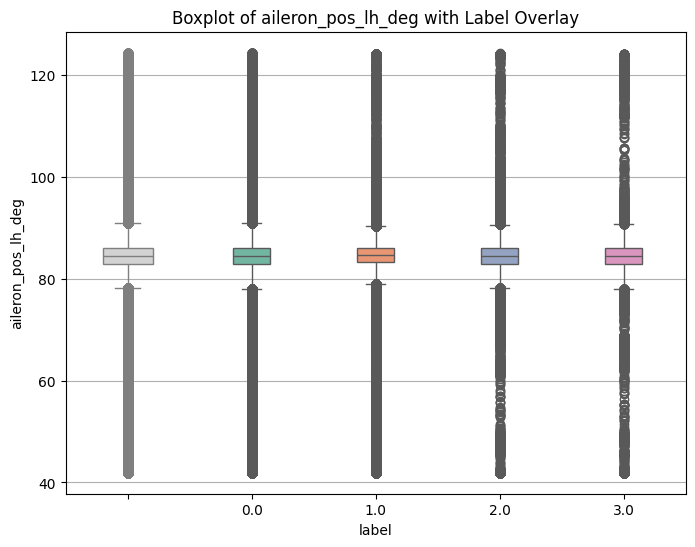

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


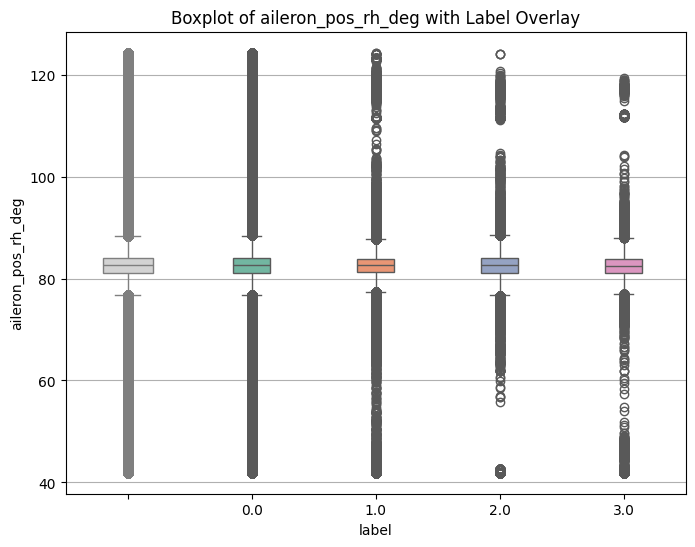

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


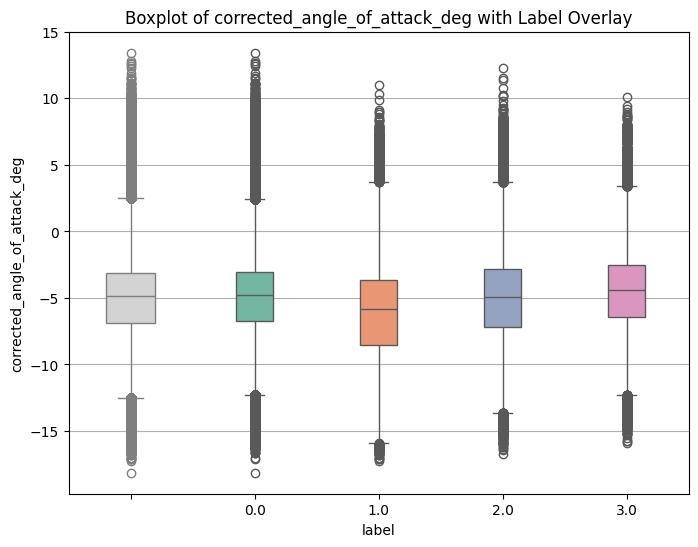

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


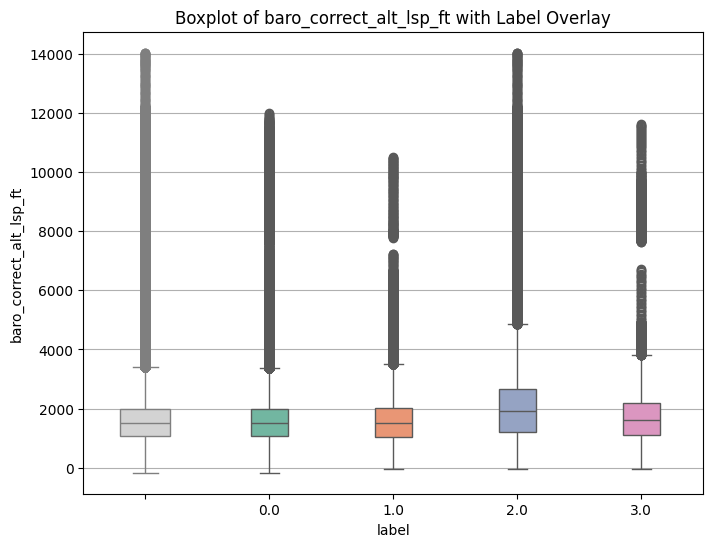

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


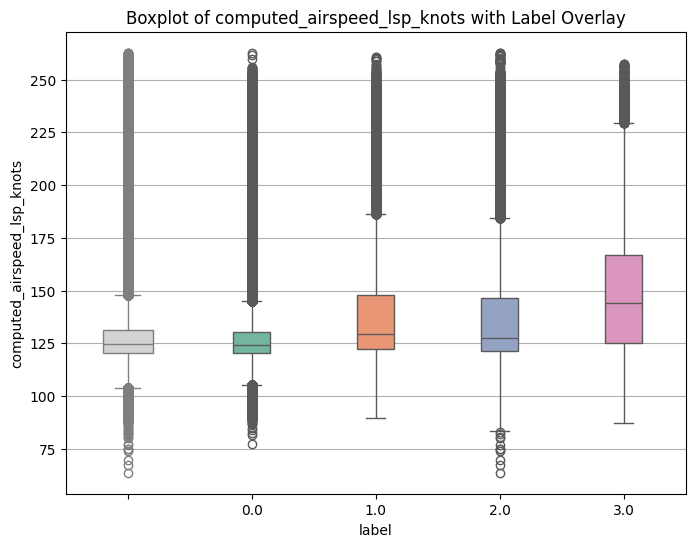

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


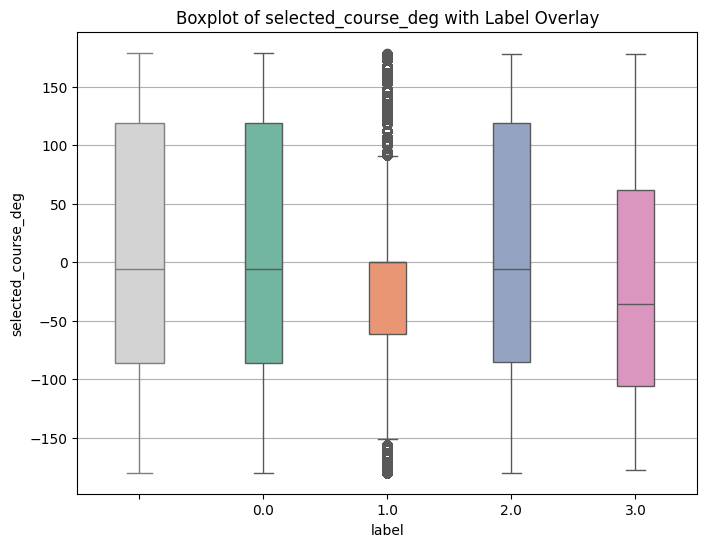

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


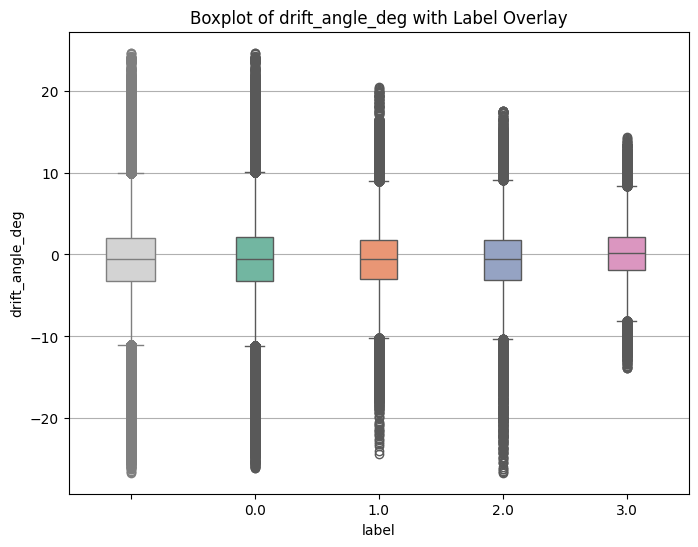

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


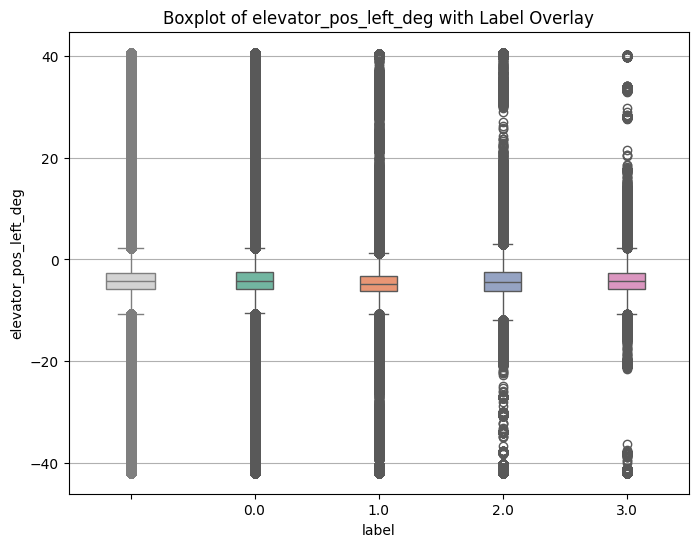

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


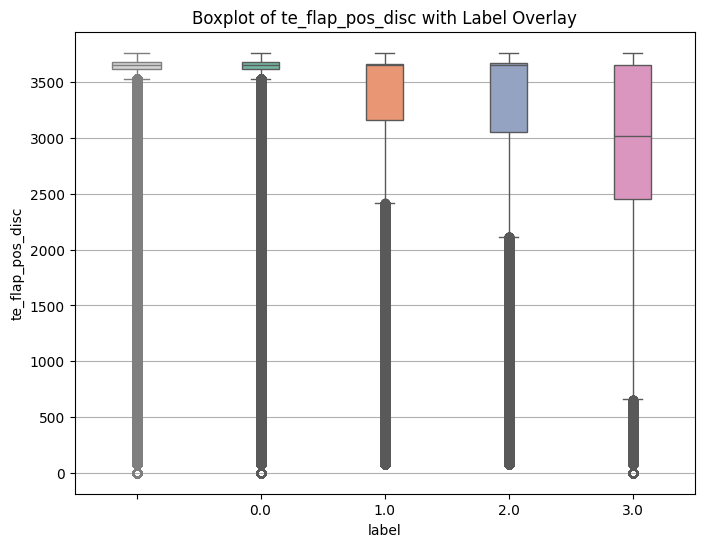

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


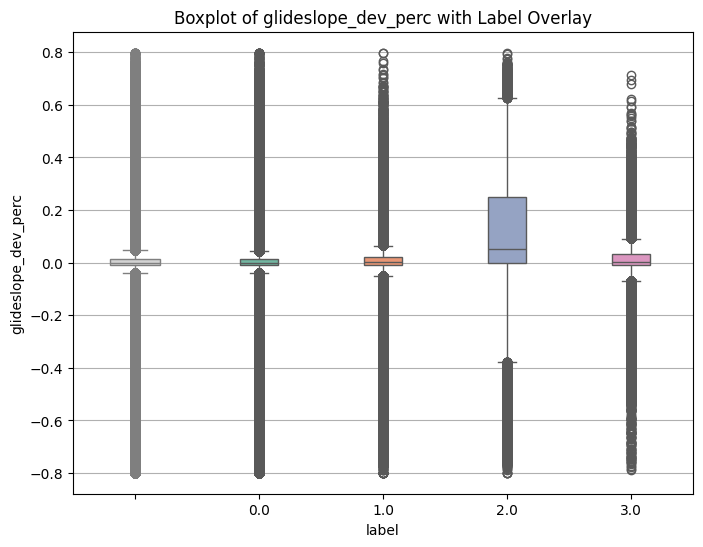

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


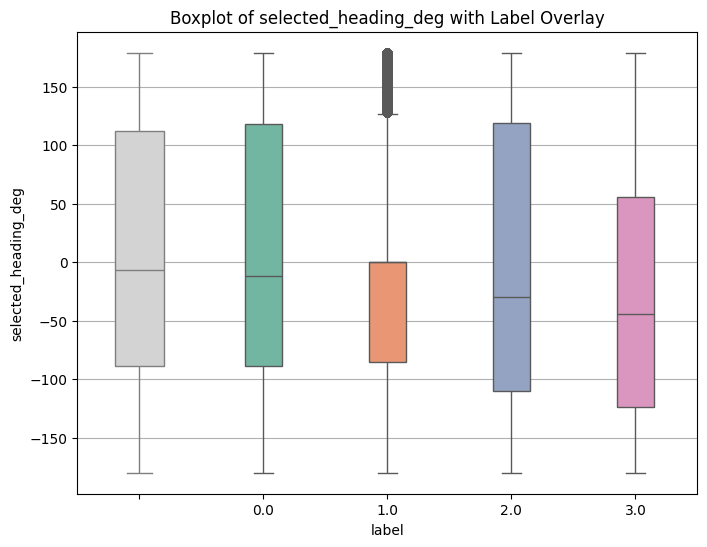

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


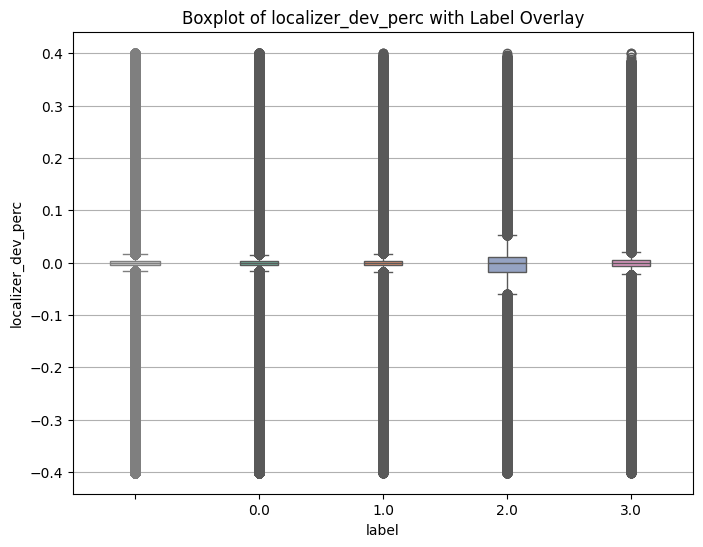

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


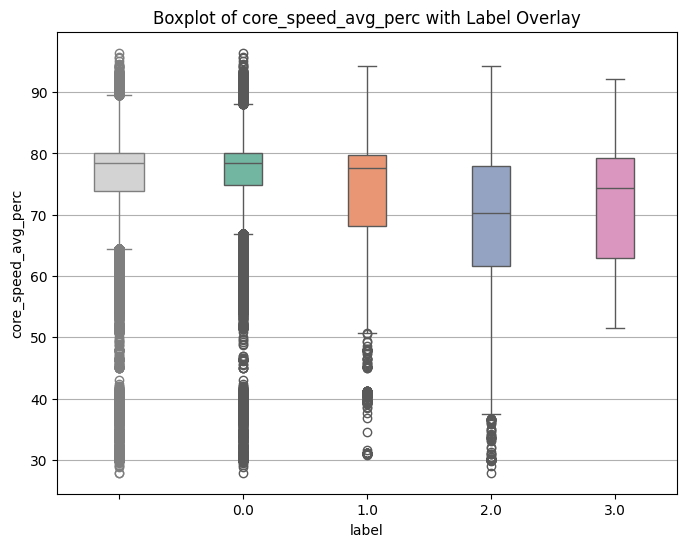

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


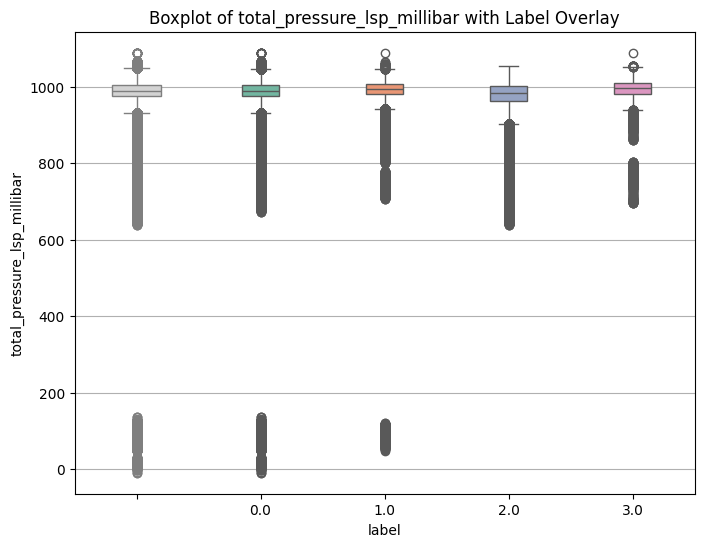

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


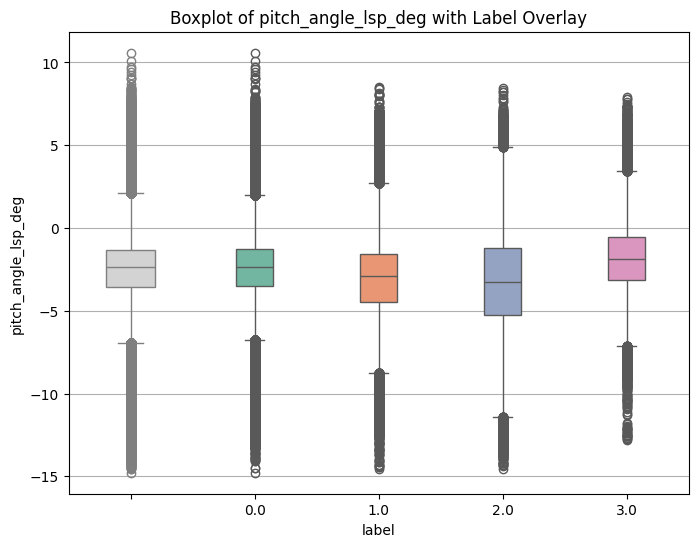

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


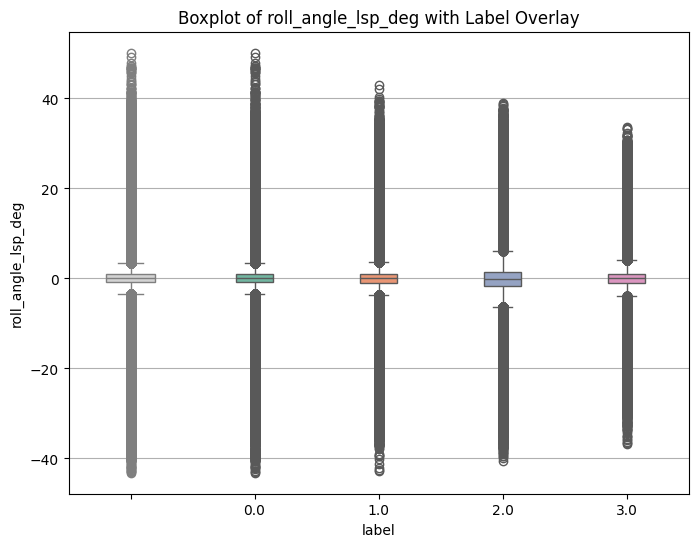

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


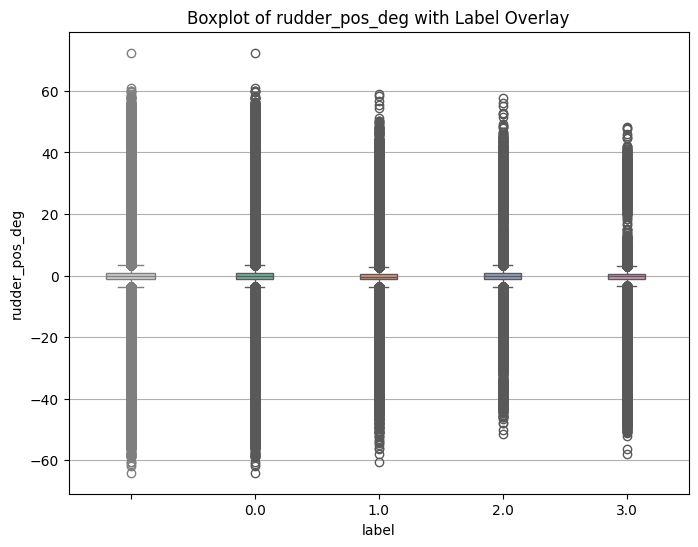

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


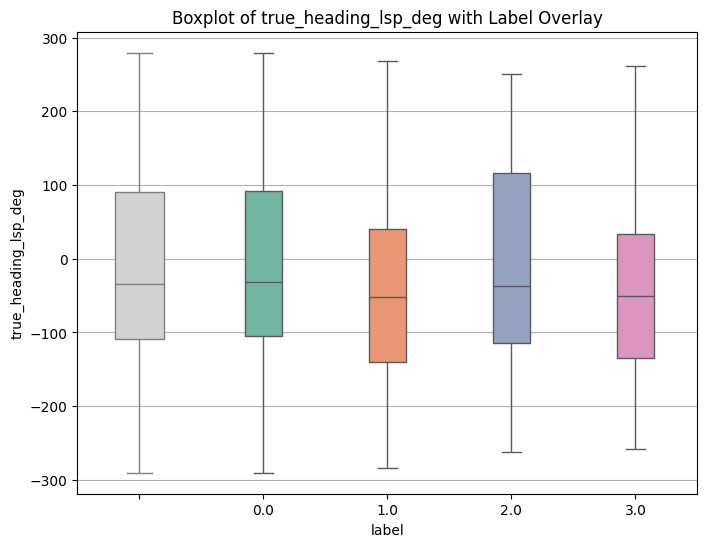

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


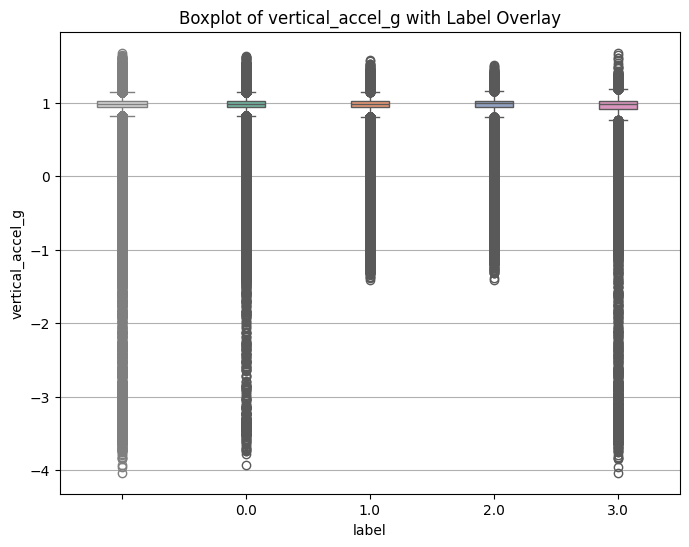

<ipython-input-8-9ebcc0f79326>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')


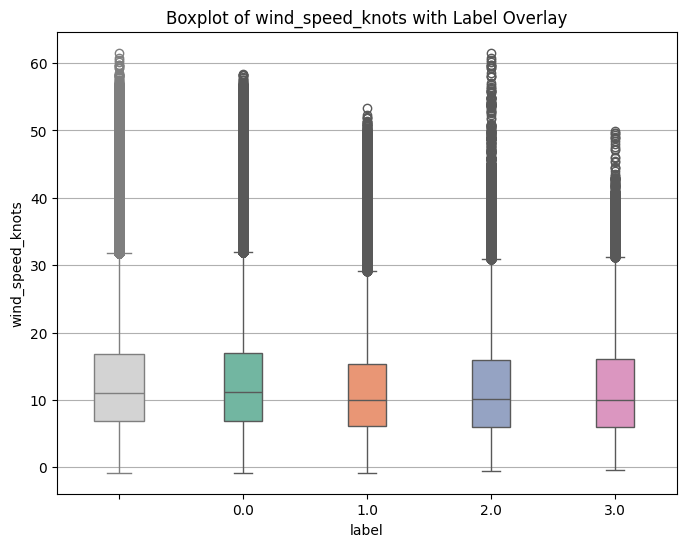

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
np.random.seed(42)


# Plotting boxplots overlaid for each variable

for var in float_columns:
    plt.figure(figsize=(8, 6))

    # Base boxplot (overall distribution)
    sns.boxplot(y=df[var], color='lightgray', width=0.4)

    # Overlay boxplot by Label
    sns.boxplot(y=var, x='label', data=df, width=0.3, palette='Set2')

    plt.title(f'Boxplot of {var} with Label Overlay')
    plt.grid(axis='y')
    plt.show()


### Variable Correlation

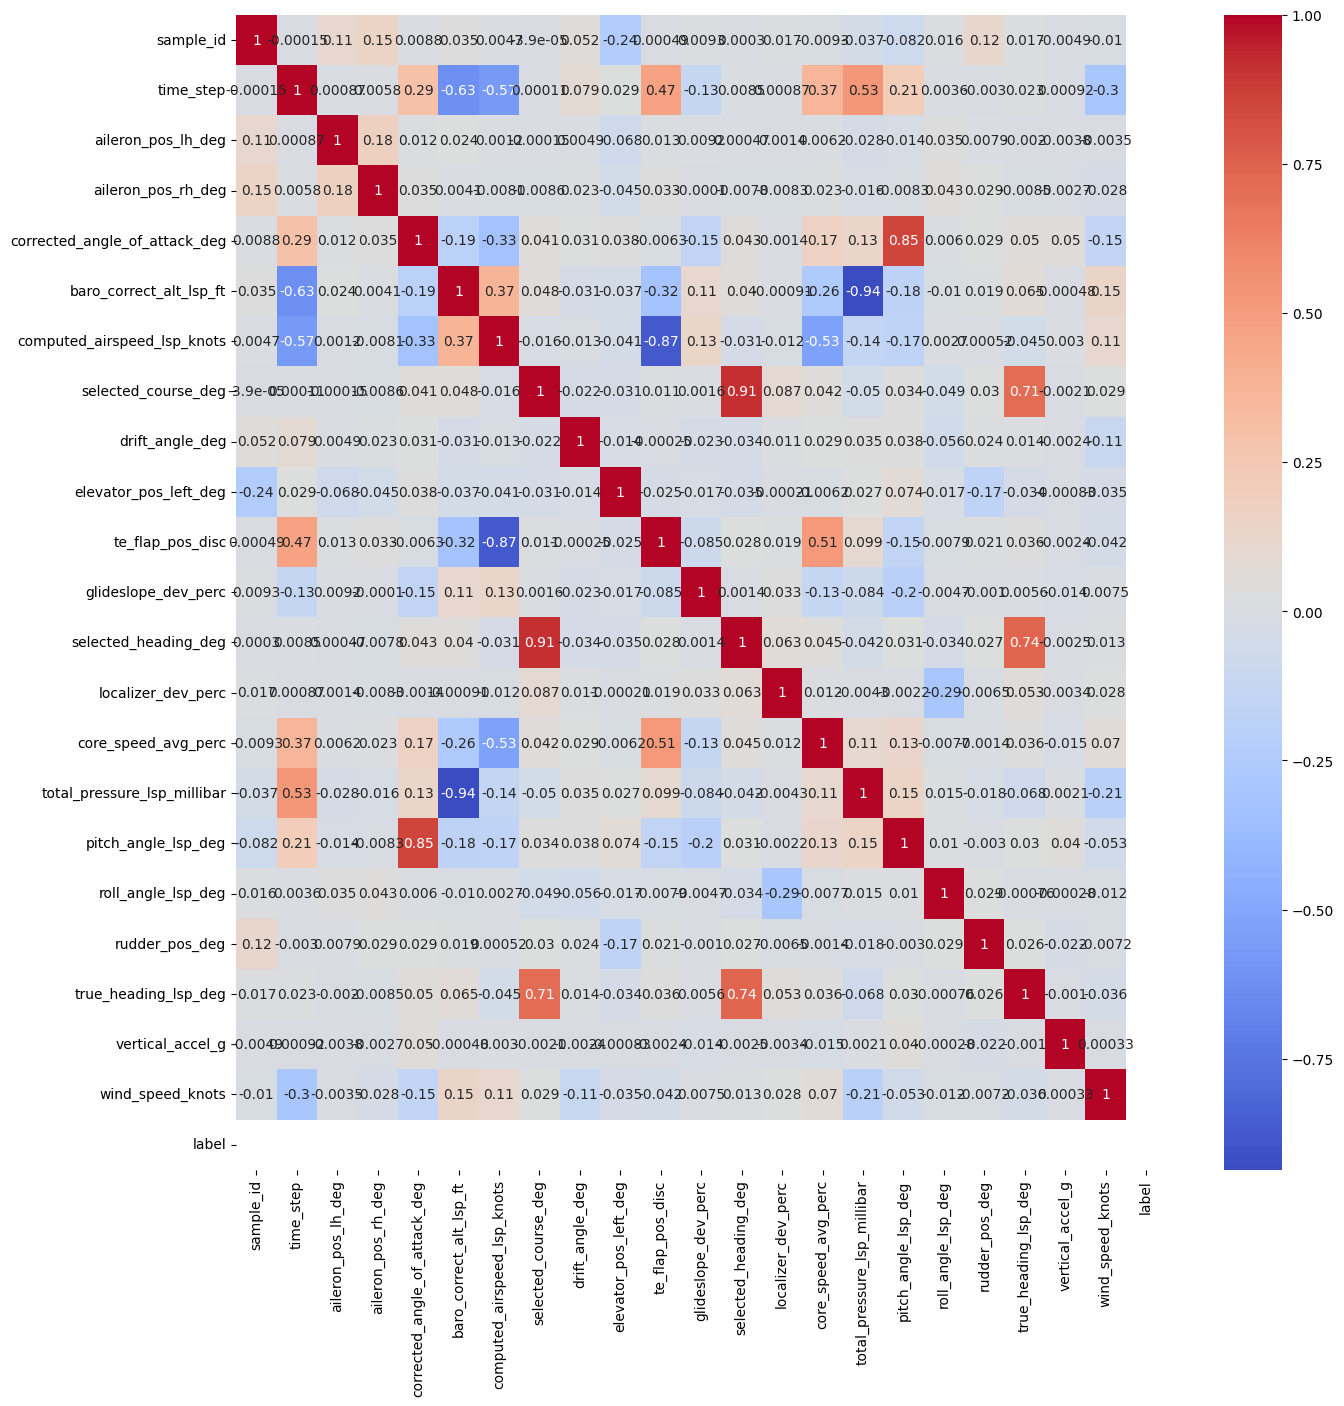

In [ ]:
import seaborn as sns

corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', )

plt.show()

In [ ]:

df["record_identifier"] = df["sample_id"].astype(str) + "_" + df["time_step"].astype(str)

df["time_step"] = df["time_step"].astype(float)
df.head()

sample_id  time_step  aileron_pos_lh_deg  aileron_pos_rh_deg  \
0          0        0.0           81.261190           82.652336   
1          0        1.0           79.604095           81.015700   
2          0        2.0           81.302110           80.770200   
3          0        3.0           82.345470           83.900276   
4          0        4.0           81.874930           82.754620   

   corrected_angle_of_attack_deg  baro_correct_alt_lsp_ft  \
0                      -8.111792                1969.6174   
1                      -7.644611                1955.6995   
2                      -7.552573                1940.0267   
3                      -8.395265                1924.5493   
4                      -7.854284                1905.3670   

   computed_airspeed_lsp_knots  selected_course_deg  drift_angle_deg  \
0                    155.57140            -2.109358        -0.692778   
1                    154.51205            -2.109358        -0.867216   
2                    153.32867            -2.109358        -1.424093   
3                    150.88818            -2.109358        -1.141912   
4                    150.69461            -2.109358        -0.724660   

   elevator_pos_left_deg  ...  core_speed_avg_perc  \
0              -4.952854  ...             70.74118   
1              -5.198349  ...             70.71775   
2              -4.830105  ...             70.70276   
3              -4.625526  ...             70.74159   
4              -4.400490  ...             70.57045   

   total_pressure_lsp_millibar  pitch_angle_lsp_deg  roll_angle_lsp_deg  \
0                    985.42550            -3.662262            0.785912   
1                    985.52030            -3.665276            0.046774   
2                    985.41650            -3.940319            0.804820   
3                    984.81710            -4.275129            1.077102   
4                    985.23065            -4.241483            1.654806   

   rudder_pos_deg  true_heading_lsp_deg  vertical_accel_g  wind_speed_knots  \
0       -0.390141             -1.081870          0.972379         12.625183   
1       -0.756234             -0.704820          0.770077         11.893839   
2       -1.325632             -0.240446          0.543937         12.559112   
3       -0.326884             -0.191627          1.062817         10.542998   
4        0.129545             -0.528425          0.867628          9.713539   

   label  record_identifier  
0    0.0                0_0  
1    0.0                0_1  
2    0.0                0_2  
3    0.0                0_3  
4    0.0                0_4  

[5 rows x 24 columns]

### Variable Distribution

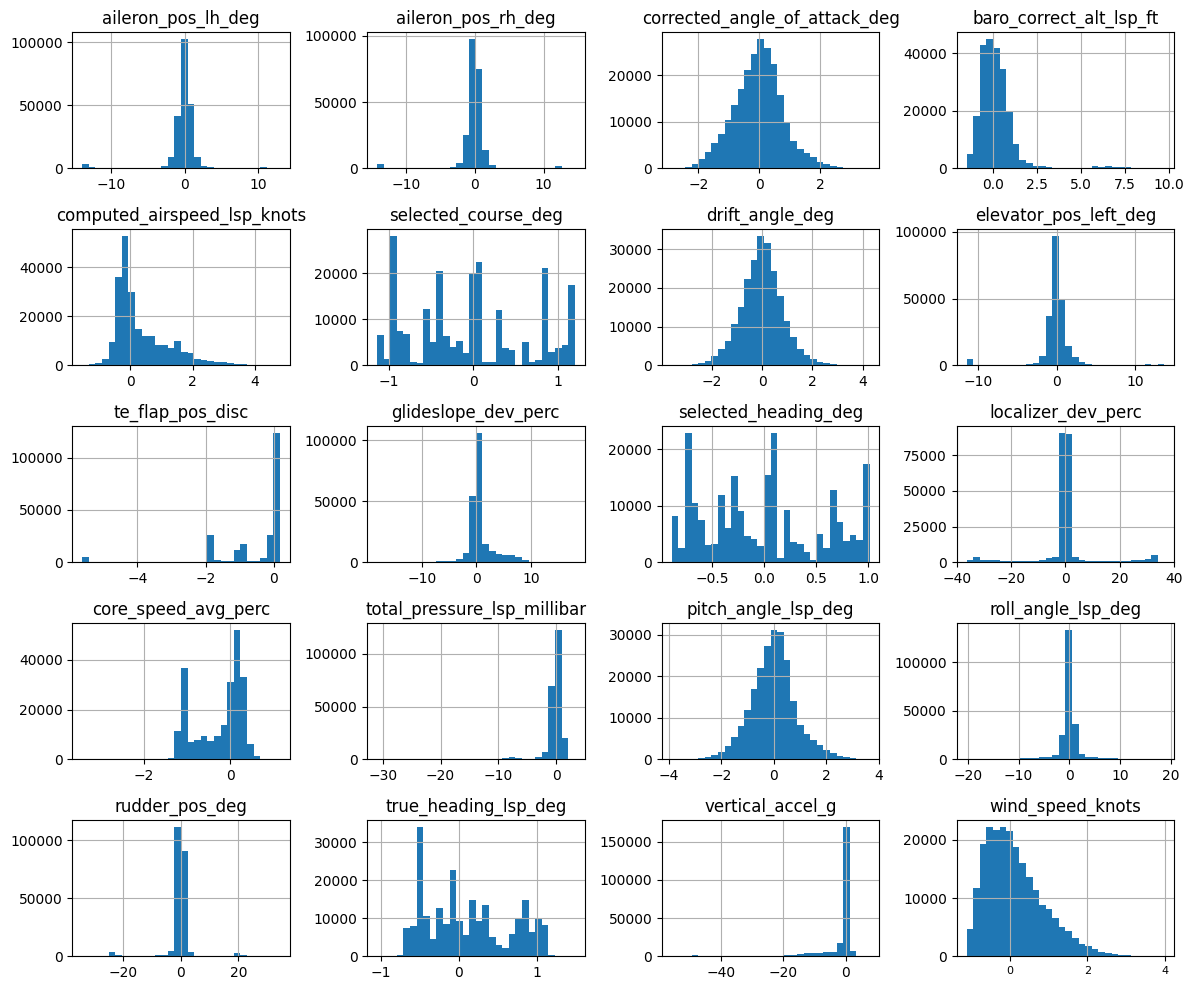

In [ ]:
import matplotlib.pyplot as plt
df_dataonly = df_scaled[float_columns]
hist = df_dataonly.hist(figsize=(12, 10),bins=30)
plt.xticks(fontsize=8)
plt.tight_layout()

### Data Visualization Using PCA and TSNE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

features = df_scaled.drop(columns=['label','sample_id'])
labels = df_scaled['label']

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, n_jobs=-1)
tsne_results = tsne.fit_transform(features)

tsne_df = pd.DataFrame({
    'TSNE-1': tsne_results[:, 0],
    'TSNE-2': tsne_results[:, 1],
    'Label': labels
})

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


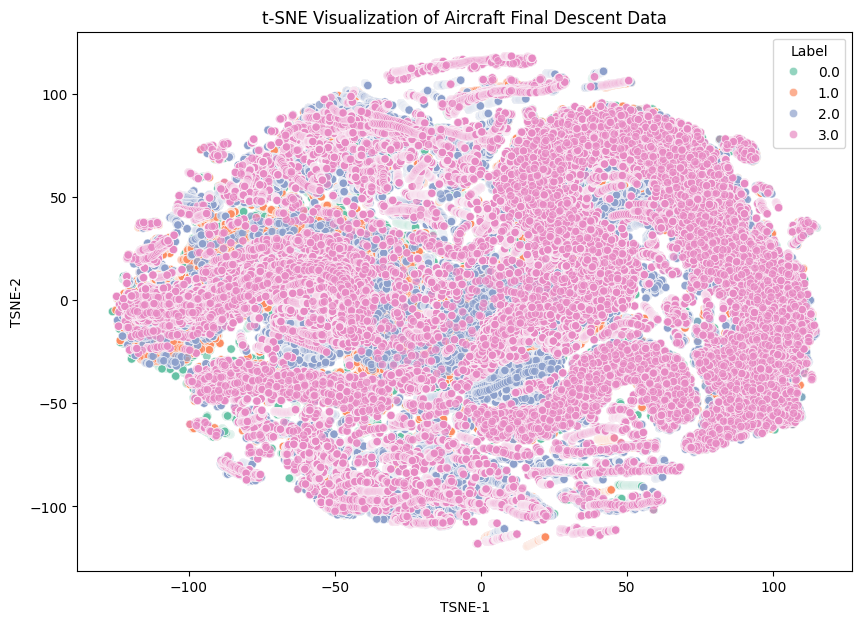

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label',
    palette='Set2',
    data=tsne_df,
    alpha=0.7
)
plt.title('t-SNE Visualization of Aircraft Final Descent Data')
plt.legend(title='Label')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

features = df_scaled.copy()
features = features[features['time_step'] > 140.0]
labels = features['label']
features = features.drop(columns=['label','sample_id'])

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, n_jobs=-1)
tsne_results = tsne.fit_transform(features)

tsne_df = pd.DataFrame({
    'TSNE-1': tsne_results[:, 0],
    'TSNE-2': tsne_results[:, 1],
    'Label': labels
})

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


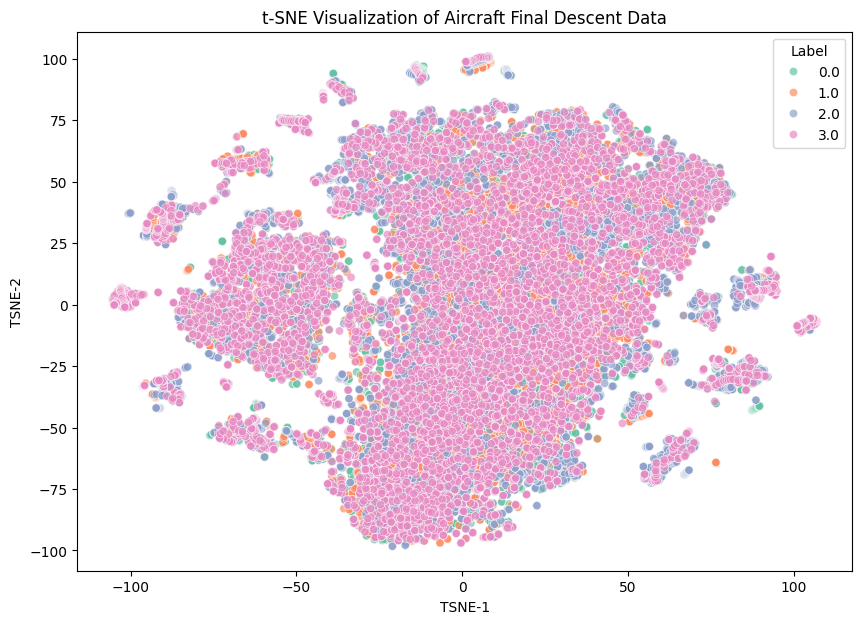

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label',
    palette='Set2',
    data=tsne_df,
    alpha=0.7
)
plt.title('t-SNE Visualization of Aircraft Final Descent Data')
plt.legend(title='Label')
plt.show()


### Representation by Arrival Airport in Training Data

In [ ]:
sample_ids = df['sample_id'].unique()
flight_metadata_df = pd.read_csv("/content/drive/MyDrive/USD (1)/FlightAnomalyClassification/DASHlink_full_fourclass_raw_meta (1).csv")
train_flight_metadata = flight_metadata_df[flight_metadata_df['data_instance'].isin(sample_ids)]
ax = df.plot.bar(x='lab', y='val', rot=0)

In [ ]:

df["record_identifier"] = df["sample_id"].astype(str) + "_" + df["time_step"].astype(str)

df["time_step"] = df["time_step"].astype(float)
df.tail()

sample_id  time_step  aileron_pos_lh_deg  aileron_pos_rh_deg  \
6389915      99835      155.0           88.114624           82.222720   
6389916      99835      156.0           81.956764           86.375694   
6389917      99835      157.0           86.396150           86.027910   
6389918      99835      158.0           85.577835           85.270966   
6389919      99835      159.0           84.636765           86.682560   

         corrected_angle_of_attack_deg  baro_correct_alt_lsp_ft  \
6389915                       6.874017                629.22797   
6389916                       6.319379                623.89624   
6389917                       4.170040                624.05475   
6389918                       1.343325                624.10240   
6389919                       1.255068                624.51654   

         computed_airspeed_lsp_knots  selected_course_deg  drift_angle_deg  \
6389915                    105.47570             34.98022        -1.176979   
6389916                    104.67262             34.98022        -1.019591   
6389917                    101.82832             34.98022        -1.167051   
6389918                     99.21132             34.98022        -0.159543   
6389919                     97.39182             34.98022         0.457792   

         elevator_pos_left_deg  ...  core_speed_avg_perc  \
6389915              -3.316216  ...            63.319550   
6389916               1.552792  ...            61.987160   
6389917               1.961948  ...            61.082344   
6389918              10.063316  ...            58.991150   
6389919               9.797363  ...            56.885094   

         total_pressure_lsp_millibar  pitch_angle_lsp_deg  roll_angle_lsp_deg  \
6389915                   1017.93130             4.400115            0.204086   
6389916                   1017.81550             4.322569           -0.970712   
6389917                   1016.82410             3.697519            0.035246   
6389918                   1015.96124             2.390611            0.591246   
6389919                   1015.51624             2.680404            0.820136   

         rudder_pos_deg  true_heading_lsp_deg  vertical_accel_g  \
6389915       -0.666766             29.992224          1.082715   
6389916       -0.622764             29.740330          1.058380   
6389917       -0.695083             29.869590          1.056430   
6389918       -0.648484             29.010420          0.966415   
6389919       -0.642458             28.177433          1.043380   

         wind_speed_knots  label  record_identifier  
6389915          3.502982    3.0          99835_155  
6389916          3.245408    3.0          99835_156  
6389917          3.285423    3.0          99835_157  
6389918          3.440334    3.0          99835_158  
6389919          2.406222    3.0          99835_159  

[5 rows x 24 columns]

## Feature Store

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup
from time import gmtime, strftime, sleep
from sagemaker.session import Session

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

record_identifer_feature_name = 'record_identifier'
event_time_feature_name = 'time_step'

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

flight_feature_group_name = "flightfeature-group-" + strftime("%d-%H-%M-%S", gmtime())
flight_feature_group = FeatureGroup(name=flight_feature_group_name, sagemaker_session=feature_store_session
                                     )

In [ ]:
df.head()

sample_id  time_step  aileron_pos_lh_deg  aileron_pos_rh_deg  \
0          0        0.0           81.261190           82.652336   
1          0        1.0           79.604095           81.015700   
2          0        2.0           81.302110           80.770200   
3          0        3.0           82.345470           83.900276   
4          0        4.0           81.874930           82.754620   

   corrected_angle_of_attack_deg  baro_correct_alt_lsp_ft  \
0                      -8.111792                1969.6174   
1                      -7.644611                1955.6995   
2                      -7.552573                1940.0267   
3                      -8.395265                1924.5493   
4                      -7.854284                1905.3670   

   computed_airspeed_lsp_knots  selected_course_deg  drift_angle_deg  \
0                    155.57140            -2.109358        -0.692778   
1                    154.51205            -2.109358        -0.867216   
2                    153.32867            -2.109358        -1.424093   
3                    150.88818            -2.109358        -1.141912   
4                    150.69461            -2.109358        -0.724660   

   elevator_pos_left_deg  ...  core_speed_avg_perc  \
0              -4.952854  ...             70.74118   
1              -5.198349  ...             70.71775   
2              -4.830105  ...             70.70276   
3              -4.625526  ...             70.74159   
4              -4.400490  ...             70.57045   

   total_pressure_lsp_millibar  pitch_angle_lsp_deg  roll_angle_lsp_deg  \
0                    985.42550            -3.662262            0.785912   
1                    985.52030            -3.665276            0.046774   
2                    985.41650            -3.940319            0.804820   
3                    984.81710            -4.275129            1.077102   
4                    985.23065            -4.241483            1.654806   

   rudder_pos_deg  true_heading_lsp_deg  vertical_accel_g  wind_speed_knots  \
0       -0.390141             -1.081870          0.972379         12.625183   
1       -0.756234             -0.704820          0.770077         11.893839   
2       -1.325632             -0.240446          0.543937         12.559112   
3       -0.326884             -0.191627          1.062817         10.542998   
4        0.129545             -0.528425          0.867628          9.713539   

   label  record_identifier  
0    0.0                0_0  
1    0.0                0_1  
2    0.0                0_2  
3    0.0                0_3  
4    0.0                0_4  

[5 rows x 24 columns]

In [ ]:
flight_feature_group.load_feature_definitions(data_frame=df)

[FeatureDefinition(feature_name='sample_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='time_step', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='aileron_pos_lh_deg', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='aileron_pos_rh_deg', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='corrected_angle_of_attack_deg', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='baro_correct_alt_lsp_ft', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='computed_airspeed_lsp_knots', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='selected_course_deg', feat

### Creation of FeatureGroups in SageMaker FeatureStore

In [ ]:
import time

def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


flight_feature_group.create(
    s3_uri=f"s3://{bucket}/feature_group",
    record_identifier_name=record_identifer_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)


wait_for_feature_group_creation_complete(feature_group=flight_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup flightfeature-group-31-02-10-56 successfully created.


In [ ]:
flight_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:817854913925:feature-group/flightfeature-group-31-02-10-56',
 'FeatureGroupName': 'flightfeature-group-31-02-10-56',
 'RecordIdentifierFeatureName': 'record_identifier',
 'EventTimeFeatureName': 'time_step',
 'FeatureDefinitions': [{'FeatureName': 'sample_id',
   'FeatureType': 'Integral'},
  {'FeatureName': 'time_step', 'FeatureType': 'Fractional'},
  {'FeatureName': 'aileron_pos_lh_deg', 'FeatureType': 'Fractional'},
  {'FeatureName': 'aileron_pos_rh_deg', 'FeatureType': 'Fractional'},
  {'FeatureName': 'corrected_angle_of_attack_deg',
   'FeatureType': 'Fractional'},
  {'FeatureName': 'baro_correct_alt_lsp_ft', 'FeatureType': 'Fractional'},
  {'FeatureName': 'computed_airspeed_lsp_knots', 'FeatureType': 'Fractional'},
  {'FeatureName': 'selected_course_deg', 'FeatureType': 'Fractional'},
  {'FeatureName': 'drift_angle_deg', 'FeatureType': 'Fractional'},
  {'FeatureName': 'elevator_pos_left_deg', 'FeatureType': 'Fractional'},
  {'Featu

In [ ]:
sagemaker_client.list_feature_groups()

{'FeatureGroupSummaries': [{'FeatureGroupName': 'neighborhood-feature-group-26-05-02-41',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:817854913925:feature-group/neighborhood-feature-group-26-05-02-41',
   'CreationTime': datetime.datetime(2025, 1, 26, 5, 2, 52, 140000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created',
   'OfflineStoreStatus': {'Status': 'Active'}},
  {'FeatureGroupName': 'neighborhood-feature-group-26-04-11-14',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:817854913925:feature-group/neighborhood-feature-group-26-04-11-14',
   'CreationTime': datetime.datetime(2025, 1, 26, 4, 11, 18, 797000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'},
  {'FeatureGroupName': 'flightfeature-group-31-02-10-56',
   'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:817854913925:feature-group/flightfeature-group-31-02-10-56',
   'CreationTime': datetime.datetime(2025, 1, 31, 2, 10, 57, 185000, tzinfo=tzlocal()),
   'FeatureGroupStatus': 'Created'},
  {'FeatureGroup

In [ ]:
flight_feature_group.ingest(data_frame=df, max_workers=5, wait=True)

In [ ]:
feats_to_quer = ['0_0','0_150']

for val in feats_to_quer:
    record_identifier_value = val

    response = featurestore_runtime.get_record(
        FeatureGroupName=neighborhood_feature_group_name,
        RecordIdentifierValueAsString=record_identifier_value,
    )

    if 'Record' in response and response['Record']:
        print("Record",val,"found:")
        for feature in response['Record']:
            print(f"{feature['FeatureName']}: {feature['ValueAsString']}")
        print("\n\n")
    else:
        print("Record",val,"not found.")
        print("\n\n")


## Training

### Class Balancing

In [ ]:
import random
num_unique = (int)(len((df[df['label'] == 3]))/160)
rand_zeroes = df[df['label'] == 0]['sample_id'].unique()
print(num_unique)
unique_zeros = random.choices(rand_zeroes, k=num_unique)
print(len(unique_zeros))
rand_ones = df[df['label'] == 1]['sample_id'].unique()
unique_ones = random.choices(rand_ones, k=num_unique)
rand_twos = df[df['label'] == 2]['sample_id'].unique()
unique_twos = random.choices(rand_twos, k=num_unique)
sampleids_to_keep = df[df['label'] == 3]['sample_id'].unique().tolist()
print(len(sampleids_to_keep))
sampleids_to_keep.extend(unique_ones)
print(len(sampleids_to_keep))
sampleids_to_keep.extend(unique_twos)
print(len(sampleids_to_keep))
sampleids_to_keep.extend(unique_zeros)
print(len(sampleids_to_keep))

training_df = df[df['sample_id'].isin(sampleids_to_keep)]

382
382
382
764
1146
1528


### Data Scaling

In [ ]:

from sklearn.preprocessing import MinMaxScaler

df_scaled = training_df.copy()
scalers = []
for col in float_columns:
  new_scaler = MinMaxScaler()
  df_scaled[col] = new_scaler.fit_transform(df_scaled[[col]])
  scalers.append(new_scaler)

In [ ]:
train_x = df_scaled.copy()
train_x = train_x.drop(columns=['label','sample_id'])
train_y = df_scaled['label']

### Import and Prepare Validation Data

In [ ]:
valid_df = pd.read_csv("/content/drive/MyDrive/USD (1)/FlightAnomalyClassification/valid_flight_data.csv")
valid_df.columns = ['sample_id', 'time_step', 'aileron_pos_lh_deg', 'aileron_pos_rh_deg', 'corrected_angle_of_attack_deg',
'baro_correct_alt_lsp_ft', 'computed_airspeed_lsp_knots',
    'selected_course_deg', 'drift_angle_deg', 'elevator_pos_left_deg', 'te_flap_pos_disc', 'glideslope_dev_perc', 'selected_heading_deg', 'localizer_dev_perc', 'core_speed_avg_perc',
    'total_pressure_lsp_millibar', 'pitch_angle_lsp_deg', 'roll_angle_lsp_deg', 'rudder_pos_deg', 'true_heading_lsp_deg', 'vertical_accel_g', 'wind_speed_knots', 'label']
valid_scaled = valid_df.copy()
for i in range (0,len(float_columns)):
  valid_scaled[float_columns[i]] = scalers[i].transform(valid_scaled[[float_columns[i]]])
#

In [ ]:
valid_x = valid_scaled.copy()
valid_x = valid_x.drop(columns=['label','sample_id'])
valid_y = valid_scaled['label']

### Modeling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.utils import to_categorical

import numpy as np

In [ ]:
!pip install --upgrade tensorflow

In [ ]:


num_samples = len(train_x) // 160
num_features = train_x.shape[1]

# Reshape the data
train_data = train_x.values.reshape((num_samples, 160, num_features))
train_y = df_scaled['label']
train_y = np.array(train_y)
train_data_y = []
for i in range(0,len(train_y),160):
  train_data_y.append(train_y[i])

train_y = np.array(train_data_y)
print(train_y)
train_y = to_categorical(train_y)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(160, num_features)))
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
hist = model.fit(train_data, train_y, epochs=100, batch_size=32)



[0. 0. 0. ... 3. 3. 3.]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,276 (87.02 KB)

 Trainable params: 22,276 (87.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2490 - loss: 1.4060
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2770 - loss: 1.3826
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2730 - loss: 1.3709
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3316 - loss: 1.3357
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3563 - loss: 1.3218
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3372 - loss: 1.3360
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3760 - loss: 1.3235
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3870 - loss: 1.2888
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4234 - loss: 1.2452
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4441 - loss: 1.2359
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4339 - loss: 1.2282
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accu

In [ ]:
num_samples = len(valid_x) // 160
num_features = valid_x.shape[1]

# Reshape the validation data similar to the training data
valid_data = valid_x.values.reshape((num_samples, 160, num_features))
valid_y = np.array(valid_y)
valid_data_y = []
for i in range(0,len(valid_y),160):
  valid_data_y.append(valid_y[i])

# generate predictions on valid data using the reshaped data
preds = model.predict(valid_data)  # Use valid_data instead of valid_x

# output classification report
import numpy as np
from sklearn.metrics import classification_report

preds = np.argmax(preds, axis=1)
print(classification_report(valid_data_y, preds)) # Use valid_data_y instead of valid_y

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86      9146
         1.0       0.22      0.64      0.33       715
         2.0       0.17      0.54      0.26       225
         3.0       0.92      0.94      0.93        97

    accuracy                           0.77     10183
   macro avg       0.57      0.72      0.60     10183
weighted avg       0.90      0.77      0.81     10183

